<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.ub.edu/waveng">
      <img src="https://github.com/dmaluenda/resources/raw/master/ub_logo.png" width="130"/>
    </a>
  </td>
  <td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/WavefrontEngUB/VeReady/blob/main/DOE/HologramGenerator.ipynb">
      <img src="https://github.com/dmaluenda/resources/raw/master/colab_logo_32px.png" />
      Run in Google Colab
    </a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/WavefrontEngUB/VeReady/blob/main/DOE/HologramGenerator.ipynb">
      <img src="https://github.com/dmaluenda/resources/raw/master/github_logo_32px.png" />
      View source on GitHub
    </a>
  </td>
  <td>
    <a href="https://github.com/WavefrontEngUB/VeReady/raw/main/DOE/HologramGenerator.ipynb">
      <img src="https://github.com/dmaluenda/resources/raw/master/download_logo_32px.png" />
      Download notebook
    </a>
</table>

In [1]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import requests
from imageio import imwrite
from pathlib import Path

In [2]:
# This Notebook uses two modules from our group pubished on GitHub. Let's take them

# The first one is a pip-structurated package that can be just pip-installed, directly from GitHub.
for tries in range(2):  # if first try fails, install it and, then, import them in the second try.
    try:
        import pyHolo
        from pyHolo.holo_generator import check_holo
        from pyHolo.holo_generator import get_holo_phase_only as get_holo
        from pyHolo.misc.report_utils import plot_entrance_beam_scalar as plot_field
    except ImportError:
        !pip install https://github.com/WavefrontEngUB/pyHolo/archive/refs/heads/master.zip

# The second one is just a small file, also in GitHub.
zernikes_dir = Path('ZernikesBeam')
zernikes_file = zernikes_dir / 'cin_propaga.py'
if not zernikes_dir.is_dir() or not (zernikes_file).is_file():
    zernikes_dir.mkdir(exist_ok=True)
    pyHolo.utils.download_from_github(zernikes_file, relative='DOE/ZernikesBeam',
                                      org='WavefrontEngUB', repo='VeReady',
                                      branch='main')

import ZernikesBeam.cin_propaga as ZernikeBeam

     | 54.6 MB 57.4 MB/s 0:00:03
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00
  Created wheel for pyHolo: filename=pyholo-0.1.0-py3-none-any.whl size=73670 sha256=6da8f68174c3280df5b4689a3f8092781f4c1ac0bd28c2debe3142a4e12dbc10
  Stored in directory: /tmp/pip-ephem-wheel-cache-6m0nafwg/wheels/d1/e4/a0/997cd8f627888741b5b2ba39e66f0cdd0f5ae68008d2035862
Successfully built pyHolo


In [3]:
# Internacional System Metric Units
m = 1
mm = 1e-3
um = 1e-6
nm = 1e-9

fig_num = 0  # Just to print Figure numbers

## DOE parameters

Fabrication limits (from mail): The DOE's sampling rate is `pixel_pitch`$=1\,\mu m$. They can print phase delays from $0$ to $2\pi$ liniarly with `phase_level`$=940$ steps.

In [4]:
pixel_pitch = 1 * um
phase_levels = 940

In [5]:
def save_holo(holo, label='holo'):
    print("Holo type is:", holo.dtype)  # check the type

    # let's save the hologram in a numpy file
    np.save(label, holo)

    # let's save the hologram in a 16-bit PNG
    imwrite(label+'.png', holo)

## Holograms generation

We will preparate 2 pairs of holograms, from the combination of 2 beams and 2 sizes. The first size, the bigger, is our preference ($7\,mm$ of diameter), while the second one is just in case the big one is not possible or so.

Regarding the beams, the first is angular symetric and do not use all the phases achievables by the fabrication process (this beam is labeled as `AmpOnly`). We show the histogram just to check the used values.
The second beam is not symetric and covers all the possible values (labeled as `FullComplex`).

In addition, we save the holograms in two formats: NumPy-file as `uint16` array and 16-bit PNG. Notice that, since the largest possible level is $940$ and it is far from $2^{16}$, PNG images look so dark.

Both beams are based on what we call Zernike's-profiled beams. They are made by a combination of Zernike's polynomials. So, let's load the coefficients to set the profile.

In [6]:
coeff = ZernikeBeam.load_coef(nterms=10)

### 1. DOE of same diameter of AOD size

The first attempt is to fabricate the DOE's diameter equals to the DOE's window's size: `beam_diameter`$=7\,mm$

Efficiency =  0.21399443238847082


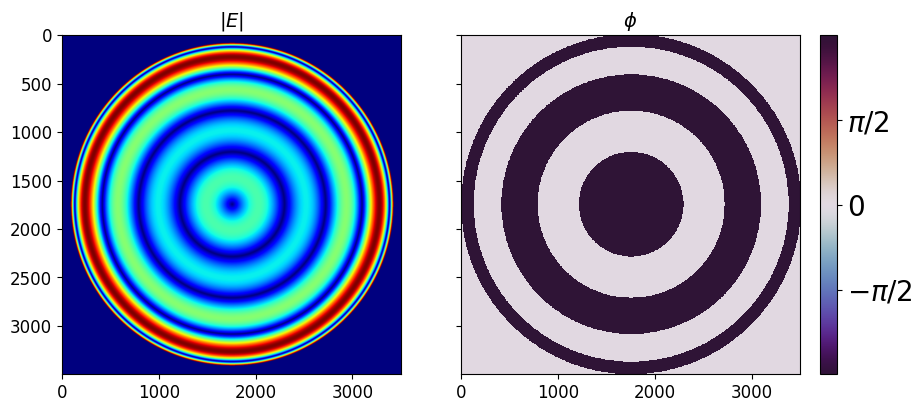

Figure 1: Zernike's beam (theoretical)


<Figure size 640x480 with 0 Axes>

In [7]:
AOD_diameter = 7 * mm

NP_AOD = int(AOD_diameter/pixel_pitch) // 2  # It's half to consider Arrizon's procedure
rho_AOD = np.linspace(1e-10,1-1e-10, NP_AOD) # radial variable @ Gaussian sphere of reference

profile_EP_AOD = ZernikeBeam.get_EP(coeff, NP_AOD, rho_AOD)
fig_num = plot_field(profile_EP_AOD, title="Zernike's beam (theoretical)", fig_num=fig_num)

Amp. Only.: 541 levels used out of 940 possible.


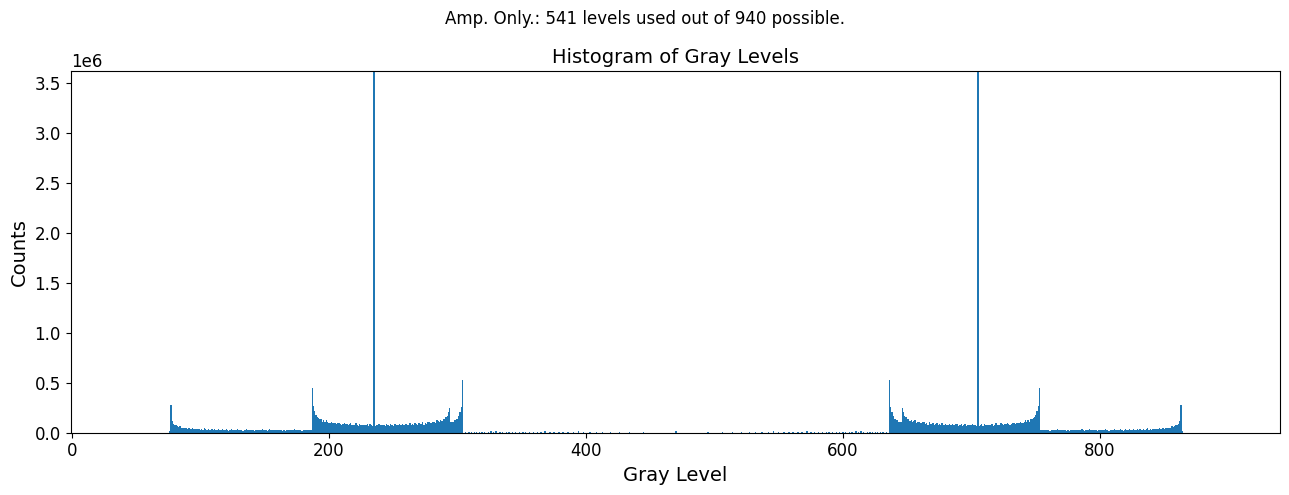

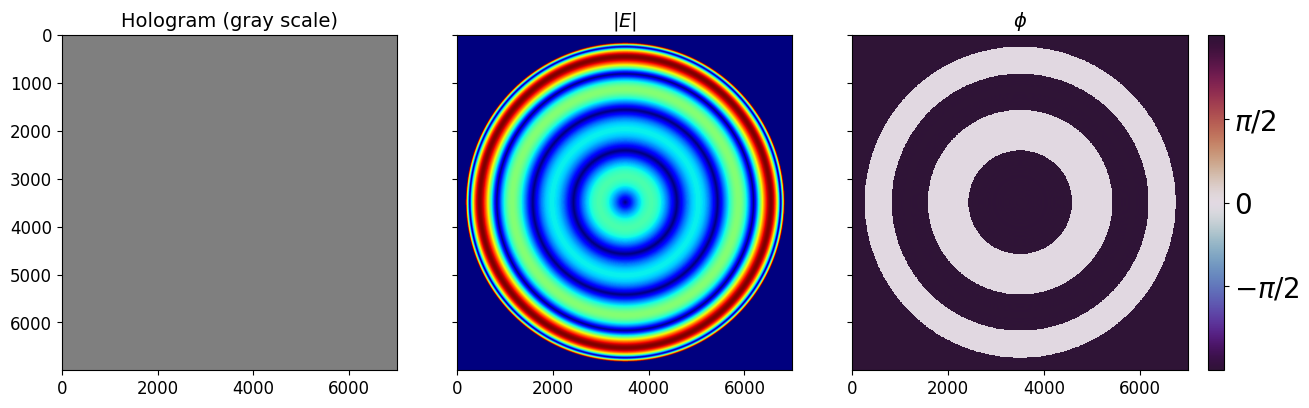

Figure 2: Just a check after holo generation (should be similar/equal to the theoretical one, but doubled in size)
Holo type is: uint16


<Figure size 640x480 with 0 Axes>

In [8]:
holo_AOD, field_AOD = get_holo(profile_EP_AOD, phase_levels)

check_holo(holo_AOD, phase_levels, label="Amp. Only.", only_hist=True)

fig_num = plot_field(field_AOD, title="Just a check after holo generation "
                                      "(should be similar/equal to the "
                                      "theoretical one, but doubled in size)",
                     holo=holo_AOD, fig_num=fig_num)
save_holo(holo_AOD, f"Zernike_AmpOnly_{AOD_diameter/mm:.0f}mm")

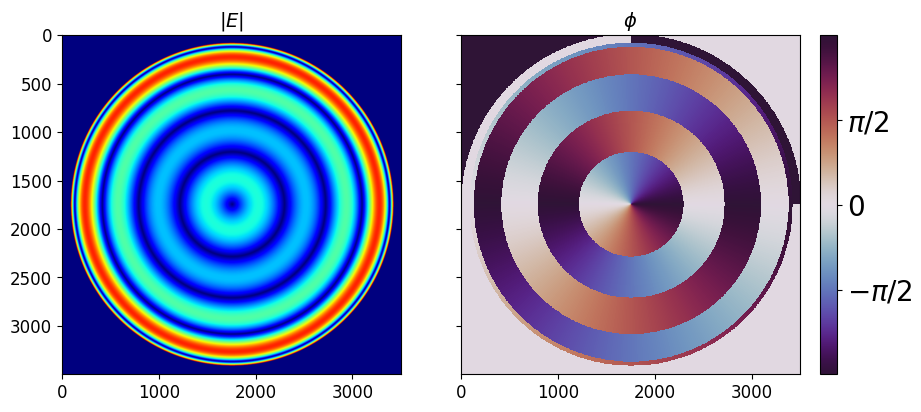

Figure 3: Zernike's beam with spiral phase. (Theoretical II)
Zernike-Spiral: 940 levels used out of 940 possible.


<Figure size 640x480 with 0 Axes>

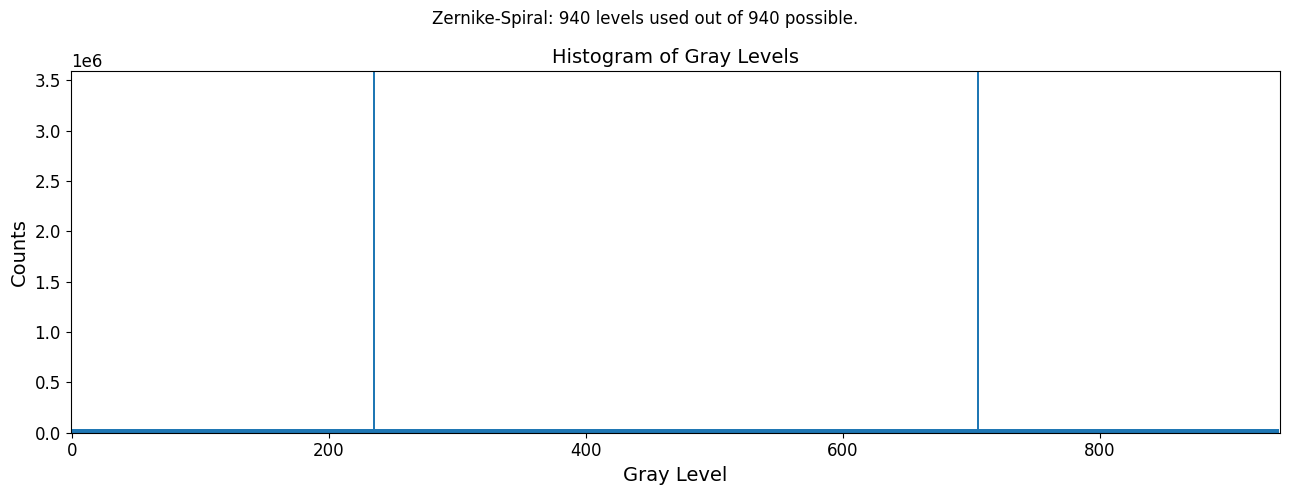

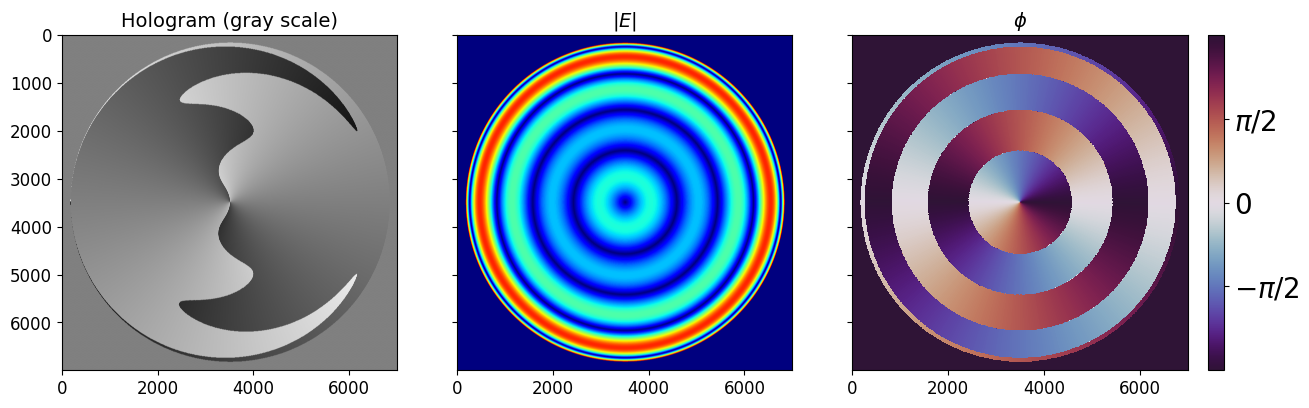

Figure 4: Just a check after holo generation (should be similar/equal to the theoretical II, but doubled in size)
Holo type is: uint16


<Figure size 640x480 with 0 Axes>

In [9]:
x, y = np.meshgrid(np.linspace(-1,1, NP_AOD), np.linspace(-1,1, NP_AOD))
phi = np.atan2(-y, x)

profile_vortex_AOD = profile_EP_AOD * np.exp(1j*phi)

fig_num = plot_field(profile_vortex_AOD,
                     title="Zernike's beam with spiral phase. "
                           "(Theoretical II)", fig_num=fig_num)

holo_vortex_AOD, field_vortex_AOD = get_holo(profile_vortex_AOD, phase_levels)

check_holo(holo_vortex_AOD, phase_levels, label="Zernike-Spiral", only_hist=True)
fig_num = plot_field(field_vortex_AOD, title="Just a check after holo generation "
                                             "(should be similar/equal to the "
                                             "theoretical II, but doubled in size)",
                     fig_num=fig_num, holo=holo_vortex_AOD)
save_holo(holo_vortex_AOD, f"Zernike_FullComplex_{AOD_diameter/mm:.0f}mm")

### 2. DOE of same size of MO diameter

The second attempt is to set the DOE's diameter equals to the Entrance Pupil of the Microscope Objective: `beam_diameter`$=4\,mm$

Efficiency =  0.2142229312566226
Holo type is: uint16


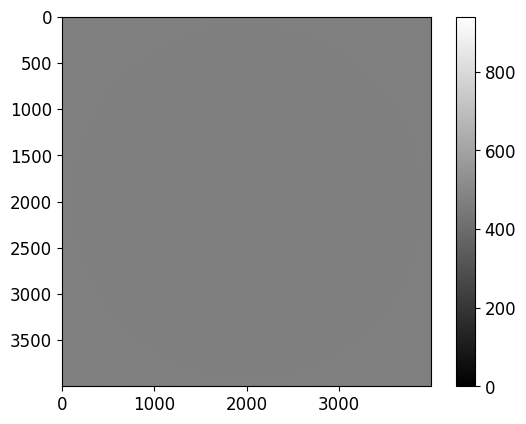

In [15]:
MO_diameter = 4 * mm

NP_MO = int(MO_diameter/pixel_pitch) // 2  # It's half to consider Arrizon's procedure
rho_MO = np.linspace(1e-10,1-1e-10, NP_MO) # radial variable @ Gaussian sphere of reference

profile_EP_MO = ZernikeBeam.get_EP(coeff, NP_MO, rho_MO)

holo_MO, field_MO = get_holo(profile_EP_MO, phase_levels)

plt.imshow(holo_MO, cmap='gray', vmin=0, vmax=phase_levels)
plt.colorbar()

save_holo(holo_MO, f"Zernike_AmpOnly_{MO_diameter/mm:.0f}mm")

Holo type is: uint16


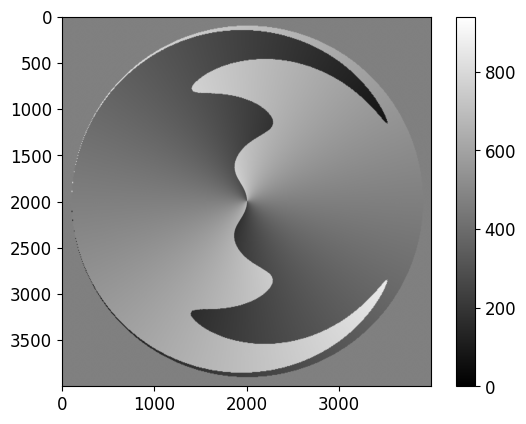

In [16]:
# The last one is a small version of the vortex-Zernike beam.

x, y = np.meshgrid(np.linspace(-1,1, NP_MO), np.linspace(-1,1, NP_MO))
phi = np.atan2(-y, x)

profile_vortex_MO = profile_EP_MO * np.exp(1j*phi)

holo_vortex_MO, field_vortex_MO = get_holo(profile_vortex_MO, phase_levels)

plt.imshow(holo_vortex_MO, cmap='gray', vmin=0, vmax=phase_levels)
plt.colorbar()

save_holo(holo_vortex_MO, f"Zernike_FullComplex_{MO_diameter/mm:.0f}mm")